Here, in this notebook, we develop the SNR features of the primary KOIS

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import time
from scipy.optimize import brute

In [2]:
file_list = np.loadtxt("../Catalogs/prim_ltf_trimmed.txt", dtype = str)
print file_list.shape
star_list = [x.split("_")[0] for x in file_list]
#print star_list

(3080,)


In [3]:
data_table = pd.read_csv("../Data/KOI_feat_files_3080_labelled_try4.csv", index_col = 0)
data_table.head()

,star_id,segment,mod_sig_pri_dv,mod_sig_sec_dv,mod_sig_ter_dv,mod_sig_pos_dv,mod_fa1_dv,mod_fa2_dv,mod_fred_dv,modshiftval1_dv,...,BLS_i2_1_0,BLS_deltaChi2_1_0,BLS_fraconenight_1_0,BLS_Npointsintransit_1_0,BLS_Ntransits_1_0,BLS_Npointsbeforetransit_1_0,BLS_Npointsaftertransit_1_0,BLS_Rednoise_1_0,BLS_Whitenoise_1_0,BLS_SignaltoPinknoise_1_0
0,10000941.0,0.0,0.00010,-9.993175,0.006914,-0.000487,2.890723,1.683670,1.005397,-2.890624,...,0.96101,-0.0,0.14202,133.0,24.0,148.0,134.0,0.00004,0.00017,5.83681
1,10000941.0,10.0,0.00015,-9.989960,0.010734,-0.007437,3.258248,2.932443,0.900412,-3.258082,...,0.57704,-0.0,0.43998,50.0,3.0,46.0,49.0,0.00002,0.00015,6.56482
2,10000941.0,11.0,0.00016,-9.993512,0.005794,-0.005094,3.213570,2.883496,0.858541,-3.213383,...,0.79830,-0.0,0.37660,47.0,3.0,50.0,50.0,0.00001,0.00015,6.88286
3,10000941.0,12.0,0.00010,-9.999314,0.001210,-0.007658,2.954473,2.416740,1.025278,-2.954375,...,0.55845,-0.0,0.36065,156.0,5.0,153.0,156.0,0.00000,0.00017,7.47269
4,10000941.0,13.0,0.00011,-9.997905,0.002758,-0.003923,3.070810,2.047990,0.988919,-3.070699,...,0.78886,-0.0,0.13157,85.0,19.0,81.0,75.0,0.00004,0.00016,5.78025


In [4]:
#loaf the primary KOI table to determine the correct period of the kois in our dataset
file_name = '../../../Training/catalogs/shortperiodbright_KOI.csv'
#koi = pd.read_csv(file_name)
koi = pd.read_csv("../Catalogs/shortperiodbright_KOI.csv")
#print koi.columns.values
print len(np.unique(koi["kepid"])),  koi.shape
star_name = koi["kepid"]
max_planets = koi["koi_tce_plnt_num"].max()
koi.head(5)

284 (392, 50)


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,4966,10000941,K04146.01,Kepler-1558 b,CONFIRMED,CANDIDATE,0.999,0,0,0,...,-139.0,4.477,0.095,-0.105,0.854,0.103,-0.093,286.81937,46.911690,13.632
1,4967,10000941,K04146.02,NaN,CANDIDATE,CANDIDATE,1.000,0,0,0,...,-139.0,4.477,0.095,-0.105,0.854,0.103,-0.093,286.81937,46.911690,13.632
2,2605,10024701,K02002.01,Kepler-1046 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-130.0,4.403,0.076,-0.114,1.053,0.168,-0.104,296.75574,46.998291,13.286
3,7125,10053138,K07279.01,NaN,CANDIDATE,CANDIDATE,0.769,0,0,0,...,-72.0,4.333,0.154,-0.126,1.056,0.191,-0.173,280.71948,47.072220,13.717
4,5105,10063208,K04292.01,Kepler-1583 b,CONFIRMED,CANDIDATE,0.995,0,0,0,...,-82.0,4.514,0.032,-0.128,0.888,0.138,-0.046,286.38693,47.016628,12.897


Here, you are generating the period error for the primary koi

In [5]:
#period error function
def period_func(vals, p_bls, p_inj):
    a, b = vals
    a = np.rint(a)
    b = np.rint(b)   
    return np.abs((a*p_bls - b*p_inj) / 0.5/(a*p_bls + b*p_inj))

In [6]:
planet_periods = np.zeros((data_table.shape[0], max_planets +1))
# have the number of max planets +1 as the max number of possible periods.
#the first indice will store the number of relevant indices
start  = time.time()

# select the planet with the largest signal for each star in the KOI list
for i in range(int(data_table.shape[0])):
    name =  data_table["star_id"][i]   #int(val.split("-")[0])
    if name in star_name.tolist():
        location = np.where(star_name== name)[0]
        period_values = koi["koi_period"][location].values
        try:
            planet_periods[i, 0] = len(period_values)
            planet_periods[i, 1: len(period_values)+1] = koi["koi_period"][location] #days          
        except:
            print name
        
    else:
        print "Not in list", name#+"ltf.lc"
    if i %1000 ==999:
        print i
    #break
   


999
1999
2999


Need to check the integers a and b and the tolerance at the same time for each period to determine which period gives the smallest error

In [7]:
rranges=(slice(1, 6, 1), slice(1, 6, 1)) #allows a and b to range from  1 to 5
harmonics_koi = np.empty(shape = [data_table.shape[0],2]) # stores a and b 
final_planet_periods = np.zeros(data_table.shape[0]) #pick only one final period for each segment
planet_location = np.zeros_like(final_planet_periods)#this is to locate the correct planet in koi table for referencing later
#all_period_options = koi["koi_period"].values
#print koi["koi_period"][1:10]
#print all_period_options

#stores final minimum error
tol_koi = np.zeros(data_table.shape[0])

#compare with previoius period error
old_Err = np.loadtxt("../Data/period_harmonics_3080_koi_signals_tol_5x5_ordered_try4.txt")

for i in range(int(tol_koi.shape[0])):
    min_period_error = np.inf #stores minimum error

    #iterate over all the planets periods detected for that segment
    for j in range(1,int(planet_periods[i, 0]+1)):
        #print planet_periods[i, :]
        results = brute(period_func, ranges=rranges, args=(data_table["BLS_Period_1_0"][i], planet_periods[i, j]), full_output=True, finish= None)
        #calucalte resulting error with that planet period and detect bls period
        period_error = period_func( results[0].astype(int), data_table["BLS_Period_1_0"][i], planet_periods[i, j])
        min_period_error = np.min([period_error, min_period_error])
        #if your minimum has changed (will atleast once at the first time):
        #print results[0], period_error, min_period_error
        if min_period_error==period_error:
            final_planet_periods[i] = planet_periods[i, j]
            harmonics_koi[i, :] =results[0]
            tol_koi[i] = period_error
            
            #check where period and star id matches
            planet_location[i] = np.where((koi["koi_period"].values == planet_periods[i,j]) * (data_table["star_id"][i] == koi["kepid"]))[0][0]
            # the extra [0] above is because the result returns two for one case since it looks like there is a duplicate entry in the table
            #print np.where(data_table["star_id"][i] == koi["kepid"] )

            #print planet_periods[i, j]
            #print koi["koi_period"][0] ==planet_periods[i, j] 
    if np.array_equal(harmonics_koi[i, :2] ,old_Err[i, :2]) ==False:
        print i, data_table["star_id"][i], data_table["segment"][i], final_planet_periods[i]
        print "New Err", tol_koi[i], "Old Err", old_Err[i, 2], 
        print harmonics_koi[i, :], old_Err[i, :2]
        print data_table["BLS_Period_1_0"][i], final_planet_periods[i]
        print "\n"

    try:
        results[0].astype(int)
    except:
        print i
    #break
print harmonics_koi.shape

/home/naireen/anaconda2/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


1 10000941.0 10.0 2.5738437
New Err 0.0220186167901 Old Err 0.0430420153514 [ 1.  4.] [ 1.  3.]
10.07115341 2.5738437


3 10000941.0 12.0 2.5738437
New Err 0.0233698396421 Old Err 0.062176730956 [ 2.  5.] [ 1.  2.]
6.58676294 2.5738437


4 10000941.0 13.0 2.5738437
New Err 0.0363888080625 Old Err 0.0603427354425 [ 5.  3.] [ 5.  2.]
1.48911493 2.5738437


7 10000941.0 1.0 2.5738437
New Err 0.0266306126871 Old Err 0.112082306382 [ 1.  5.] [ 1.  4.]
12.53100672 2.5738437


9 10000941.0 3.0 2.5738437
New Err 0.0203919141313 Old Err 0.0414158551044 [ 3.  3.] [ 4.  3.]
2.52188784 2.5738437


10 10000941.0 4.0 2.5738437
New Err 0.0303129257745 Old Err 0.0552383776068 [ 1.  5.] [ 1.  4.]
13.26532575 2.5738437


11 10000941.0 5.0 2.5738437
New Err 0.0178080563637 Old Err 0.0388328017346 [ 3.  5.] [ 4.  5.]
4.21402177 2.5738437


13 10000941.0 7.0 2.5738437
New Err 0.0341038857414 Old Err 0.0626262075093 [ 2.  1.] [ 3.  1.]
1.24376866 2.5738437


46 10130039.0 1.0 5.47033376
New Err 0.0003617918

In [8]:
print koi["koi_period"].values[[233, 389]]
print koi["kepid"].values[[233, 389]]
print koi.shape
pd.set_option("display.max_columns",999)
koi.loc[[233, 389]]

[ 18.36974658  18.36974658]
[9963524 9963524]
(392, 50)


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
233,983,9963524,K00720.03,Kepler-221 e,CONFIRMED,CANDIDATE,1.0,0,0,0,0,18.369747,0.000086,-0.000086,131.86573,0.00363,-0.00363,0.947,0.025,-0.693,2.939,0.152,-0.152,1143.3,64.1,-64.1,3.58,0.26,-0.2,582.0,NaN,NaN,27.14,6.76,-4.75,20.1,3,q1_q17_dr25_tce,5244.0,105.0,-105.0,4.538,0.045,-0.055,0.81,0.06,-0.044,296.65475,46.83527,13.749
389,983,9963524,K00720.03,Kepler-221 e,CONFIRMED,CANDIDATE,1.0,0,0,0,0,18.369747,0.000086,-0.000086,131.86573,0.00363,-0.00363,0.947,0.025,-0.693,2.939,0.152,-0.152,1143.3,64.1,-64.1,3.58,0.26,-0.2,582.0,NaN,NaN,27.14,6.76,-4.75,20.1,3,q1_q17_dr25_tce,5244.0,105.0,-105.0,4.538,0.045,-0.055,0.81,0.06,-0.044,296.65475,46.83527,13.749


(3080, 2) (3080,)
(3080, 3)
1185


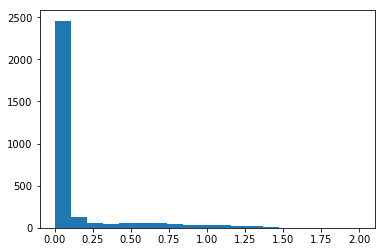

In [9]:
plt.hist(tol_koi, bins = np.linspace(0,2,20))
print harmonics_koi.shape, tol_koi.shape
#Here is the error distribution of the primary KOI
tot_vals_koi = np.hstack([harmonics_koi, tol_koi.reshape(harmonics_koi.shape[0], 1)]) 
print tot_vals_koi.shape
print len(np.where(tol_koi<0.002)[0])

In [10]:
np.savetxt("../Data/period_harmonics_3080_koi_signals_tol_5x5_ordered_multiplanet.txt", tot_vals_koi)
np.savetxt("../Data/koi_periods_multiplanet.txt", final_planet_periods)


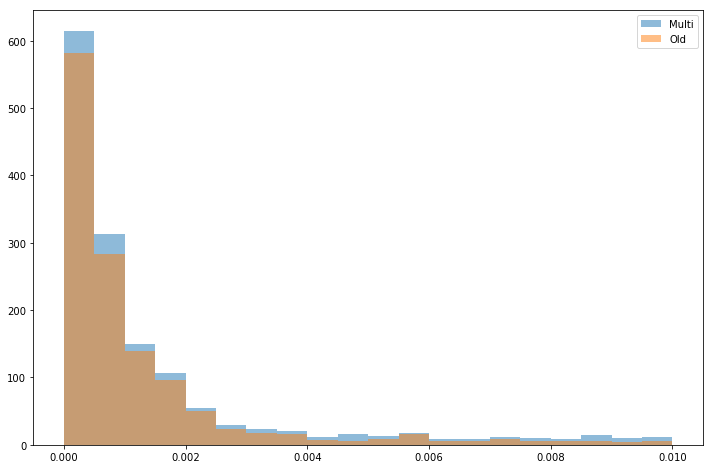

Multi 1185
Old 1101
[ 0.      0.0005  0.001   0.0015  0.002   0.0025  0.003   0.0035  0.004
  0.0045  0.005   0.0055  0.006   0.0065  0.007   0.0075  0.008   0.0085
  0.009   0.0095  0.01  ]


In [11]:
old_tols = np.loadtxt("../Data/period_harmonics_3080_koi_signals_tol_5x5_ordered_try2.txt")
plt.figure(figsize = (12, 8))
plt.hist(tol_koi, bins = np.linspace(0,.01,21), alpha = 0.5, label = "Multi")
plt.hist(old_tols[:, -1], bins = np.linspace(0,.01,21), alpha = 0.5, label = "Old")
plt.legend()
plt.show()


print "Multi", len(np.where(tol_koi <=0.002)[0])
print "Old", len(np.where(old_tols[:,-1] <0.002)[0])
print np.linspace(0,.01,21)

1622
[2014  416  109   37   34   23   32   20   29   29   30   26   25   25   23
   17   27   22   14   21]
[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.  ]
2430


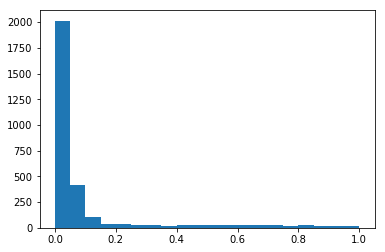

In [12]:
print len(np.where(tol_koi<0.02)[0])
n, bins, patches = plt.hist(tol_koi, bins = np.linspace(0,1,21))
print n.astype(int)
print bins
print len(np.where(tol_koi<0.1)[0])

Now that the period that gives the minimu error has been determined, we can find the SNR with that period value

In [13]:
star_name = koi["kepid"].values
inds = np.where(koi["koi_model_snr"]==np.nan)[0]
koi["koi_model_snr"][inds]==0.


SNR = np.zeros(len(star_list))
star_name_id = np.zeros_like(SNR)
star_segment = np.zeros_like(SNR)



start  = time.time()

#print final_planet_periods[0]
#if final_planet_periods[0] in koi["koi_period"].values:
    #print "its in here"

for i, val in enumerate(star_list): # list of star names and star segments
    name = int(val.split("-")[0]) # starname
    file_name = val#(val.split("-")[0]) + "-"+(val.split("-")[1]).split("_")[0]
    print val
    if name in star_name.tolist():
        #print "Hello"
        lc_data = np.loadtxt("../../../LCData/primaryKOI_try2/"+file_name+"_prim_ltf.lc")
        #print name, final_planet_periods[i]
        #print periods
        #location = np.where(final_planet_periods[i] == koi["koi_period"].values)[0]
        period_of_interest = final_planet_periods[i] # this is the minimum planet period
        #print np.where(period_of_interes)
        #print period_of_interest
        #location = np.where(period_of_interest== koi["koi_period"].values)[0]
        #location = np.where((koi["kepid"].values== int(name)))[0]
        #print koi[["kepid", "koi_period"]].shape, koi["koi_period"].shape
        location = planet_location[i]
        #planet_num = 0
        
        
        
        

        try:
            #print "He"

            #the factor of dividing it by 110 is becuase prad is given in Earth Radii
            depth = ((koi["koi_prad"][location]/ koi["koi_srad"][location])/float(110))**2      
            period = koi["koi_period"][location] #days
            duration = koi["koi_duration"][location] #hours
            model_snr = koi["koi_model_snr"][location]
            n_points = np.floor(duration * 2) # assuming duration is given in hours, as days does not make sense
            meidan = np.median(lc_data[:,2]) # flux
            error = np.median(np.abs(lc_data[:,2]-meidan)**2)**0.5
            n_transits = float(26)//float(period) +1
           
            SNR[i] = depth*np.sqrt(n_transits) * np.sqrt(n_points)/(error*np.sqrt(2))
            star_name_id[i] = val.split("-")[0]
            star_segment[i] = (val.split("-")[1]).split("_")[0]
        except Exception as e:
            print e
            continue   
        #break
       
    else:
        print "Not in list", val[:-17]#+"ltf.lc"
        #break
    if i %1000 ==999:
        print i
print SNR.shape, star_name_id.shape, star_segment.shape

10000941-0
10000941-10
10000941-11
10000941-12
10000941-13
10000941-14
10000941-15
10000941-1
10000941-2
10000941-3
10000941-4
10000941-5
10000941-6
10000941-7
10000941-8
10000941-9
10024701-0
10024701-1
10024701-2
10024701-3
10024701-4
10024701-5
10024701-6
10024701-7
10024701-8
10024701-9
10053138-0
10053138-1
10053138-2
10053138-3
10053138-4
10053138-5
10053138-6
10063208-0
10063208-1
10063208-2
10063208-3
10063208-4
10063208-5
10063208-6
10063208-7
10063208-8
10063208-9
10130039-0
10130039-10
10130039-11
10130039-1
10130039-2
10130039-3
10130039-4
10130039-5
10130039-6
10130039-7
10130039-8
10130039-9
10154388-0
10154388-10
10154388-11
10154388-1
10154388-2
10154388-3
10154388-4
10154388-5
10154388-6
10154388-7
10154388-8
10154388-9
10155029-0
10155029-1
10155029-2
10155029-3
10155029-4
10155029-5
10155029-6
10155029-7
10158418-0
10158418-10
10158418-11
10158418-1
10158418-2
10158418-3
10158418-4
10158418-5
10158418-6
10158418-7
10158418-8
10158418-9
10187017-0
10187017-1
10187017-

In [14]:
size = SNR.shape[0]
SNR_feats = np.hstack([star_name_id.reshape(size, 1), star_segment.reshape(size,1), SNR.reshape(size, 1)])
print SNR_feats.shape
print star_name_id, star_segment, SNR
np.savetxt("../Data/SNR_feats_KOIS_3080_fixed_multiplanet.txt", SNR_feats)


(3080, 3)
[ 10000941.  10000941.  10000941. ...,   9995402.   9995402.   9995402.] [  0.  10.  11. ...,   4.   5.   6.] [ 2.33918841  1.52759378  2.48741421 ...,  1.85245749  2.64456964
  2.30494525]


In [15]:
data = np.loadtxt("../Data/SNR_feats_KOIS_3080_fixed_multiplanet.txt")
print data

[[  1.00009410e+07   0.00000000e+00   2.33918841e+00]
 [  1.00009410e+07   1.00000000e+01   1.52759378e+00]
 [  1.00009410e+07   1.10000000e+01   2.48741421e+00]
 ..., 
 [  9.99540200e+06   4.00000000e+00   1.85245749e+00]
 [  9.99540200e+06   5.00000000e+00   2.64456964e+00]
 [  9.99540200e+06   6.00000000e+00   2.30494525e+00]]
